## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [129]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.
import seaborn as sns
from itertools import chain
from skimage.io import imread,imshow
import matplotlib.image as mpimg #read png files
from scipy.ndimage import gaussian_filter
import scipy
from random import sample
import sklearn.model_selection as skl
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout,Flatten,Conv2D,MaxPooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler,EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import binarize
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix

# Table of Contents
- [Data Import and Cleanse](#data-import)
- [Create Train and Validation data splits](#data-splits)
- [Build and Train Model with Keras](#model-build-train)
    - [Data batching with ImageDataGenerator](#image-gen)
    - [Fine-Tune the VGG16 Model](#model-build)
    - [Train the new Model](#model-train)
- [Model Evaluation](#model-eval)
    - [ROC, Precision-Recall Curve, F1 Plot](#metrics-plots)
    - [Threshold Optimization](#thresholding)
- [Results and Discussion](#results)

<a name="data-import"></a>
## Do some early processing of your metadata for easier model training: 

In [130]:
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/home/shafeenkhan/Documents/My-all-programs--/Semester-4/Aritificial Intelligence/Pneumonia_Detection_ChestX/data/Data_Entry_2017.csv')

all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/home/shafeenkhan/Documents/My-all-programs--/Semester-4/Aritificial Intelligence/Pneumonia_Detection_ChestX/data','images*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)

pd.set_option('display.max_columns', None)
all_xray_df.head()
print(len(all_image_paths))


Scans found: 4999 , Total Headers 112120
4999


In [131]:
# Check the count of NaN values in the 'path' column
print(all_xray_df['path'].isnull().sum())

# Drop NaN values from the 'path' column and assign the result back to all_xray_df
all_xray_df = all_xray_df.dropna(subset=['path'])

# Verify that there are no NaN values in the 'path' column after dropping
print(all_xray_df['path'].isnull().sum())


107121
0


In [132]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

all_labels=np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels=[x for x in all_labels if len(x)>0]
print(all_labels)

for label in all_labels:
    if len(label)>1:
        all_xray_df[label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if label in finding else 0)

        
all_xray_df.head()

['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN,/home/shafeenkhan/Documents/My-all-programs--/...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN,/home/shafeenkhan/Documents/My-all-programs--/...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN,/home/shafeenkhan/Documents/My-all-programs--/...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN,/home/shafeenkhan/Documents/My-all-programs--/...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN,/home/shafeenkhan/Documents/My-all-programs--/...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [133]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

all_xray_df['pneumonia_class']=all_xray_df['Pneumonia'].replace({0.0:'Negative',1.0:'Positive'})
all_xray_df[all_xray_df['pneumonia_class']== 'Positive']

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class
48,00000013_010.png,Effusion|Pneumonia|Pneumothorax,10,13,60,M,AP,3056,2544,0.139,0.139,NaN,/home/shafeenkhan/Documents/My-all-programs--/...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,Positive
126,00000032_012.png,Atelectasis|Consolidation|Edema|Pneumonia,12,32,55,F,AP,2500,2048,0.168,0.168,NaN,/home/shafeenkhan/Documents/My-all-programs--/...,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Positive
253,00000056_000.png,Nodule|Pneumonia,0,56,76,M,PA,2500,2048,0.168,0.168,NaN,/home/shafeenkhan/Documents/My-all-programs--/...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,Positive
276,00000061_012.png,Edema|Effusion|Infiltration|Pleural_Thickening...,12,61,77,M,AP,3056,2544,0.139,0.139,NaN,/home/shafeenkhan/Documents/My-all-programs--/...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,Positive
279,00000061_015.png,Pneumonia,15,61,77,M,AP,3056,2544,0.139,0.139,NaN,/home/shafeenkhan/Documents/My-all-programs--/...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4795,00001285_001.png,Edema|Infiltration|Pneumonia,1,1285,33,M,AP,2500,2048,0.168,0.168,NaN,/home/shafeenkhan/Documents/My-all-programs--/...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,Positive
4796,00001285_002.png,Edema|Infiltration|Pneumonia,2,1285,33,M,AP,2500,2048,0.168,0.168,NaN,/home/shafeenkhan/Documents/My-all-programs--/...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,Positive
4875,00001301_039.png,Edema|Effusion|Pneumonia,39,1301,57,F,AP,2500,2048,0.168,0.168,NaN,/home/shafeenkhan/Documents/My-all-programs--/...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Positive
4926,00001317_000.png,Infiltration|Pneumonia,0,1317,48,M,PA,2954,2991,0.143,0.143,NaN,/home/shafeenkhan/Documents/My-all-programs--/...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,Positive


## Create your training and testing data: <a name="data-splits"></a>

Based on EDA work, the Data_Entr_2017.cvs contains 1,431 Images positive for Pneumonia and 110,689 Images negative for Pneumonia.

The data set will be split into 80% Training data and 20% for testing data.

For the training data set, the positive to negative images must be equal in number.  Demographics such as age and gender must reflect the general data set.  Pneumonia Positive =1144.8 counts, Pneumonia Negative = 1144.8 counts

For the validation data set, positive to negative Pneumonia cases, as well as demographics, must reflect the general data set.  
Pneumonia Positive =286.2 counts, Pneumonia Negative = 22,137.8 counts

In [134]:
def create_splits(df_name):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    train_data, val_data=skl.train_test_split(df_name,
                                              test_size=0.2,
                                             stratify=df_name['Pneumonia'])
    
    #balance train_data
    p_ind=train_data[train_data['pneumonia_class']=='Positive'].index.tolist()
    n_ind=train_data[train_data['pneumonia_class']=='Negative'].index.tolist()
    n_sample = sample(n_ind,len(p_ind))
    train_data=train_data.loc[p_ind+n_sample]
    
    """balance val_data.  In the clinical setting where this algorithm will be deployed, 
    patients are being x-rayed based on their clinical symptoms that make Pneumonia 
    highly likely.  The prevalence of Pneumonia is about 20% of those who are x-rayed."""
    vp_ind=val_data[val_data['pneumonia_class']=='Positive'].index.tolist()
    vn_ind=val_data[val_data['pneumonia_class']=='Negative'].index.tolist()
    vn_sample = sample(vn_ind,4*len(vp_ind))
    val_data=val_data.loc[vp_ind+vn_sample]
    
    return train_data, val_data

In [135]:
train_data, val_data = create_splits(all_xray_df)

In [136]:
(train_data['pneumonia_class']=='Positive').value_counts()

pneumonia_class
True     52
False    52
Name: count, dtype: int64

In [137]:
(val_data['pneumonia_class']=='Negative').value_counts()

pneumonia_class
True     52
False    13
Name: count, dtype: int64

#### train_data and val_data have the correct number of Pneuominia-positive and Pneumonia-negative cases in each set.

In [138]:
#check train_data distribution for changes in Age distribution of Males with Pneumonia
scipy.stats.ttest_ind(all_xray_df['Patient Age'][(all_xray_df['Pneumonia']==True) & (all_xray_df['Patient Gender']=='M')],
                     train_data['Patient Age'][(train_data['Pneumonia']==True) & (train_data['Patient Gender']=='M')]
)

TtestResult(statistic=-0.33011002462014627, pvalue=0.7423467983668198, df=67.0)

In [139]:
#check train_data distribution for changes in Age distribution of Females with Pneumonia
scipy.stats.ttest_ind(all_xray_df['Patient Age'][(all_xray_df['Pneumonia']==True) & (all_xray_df['Patient Gender']=='F')],
                     train_data['Patient Age'][(train_data['Pneumonia']==True) & (train_data['Patient Gender']=='F')]
)

TtestResult(statistic=0.24749954692608628, pvalue=0.8056230495565373, df=46.0)

In [140]:
train_data['Patient Gender'].value_counts()

Patient Gender
M    57
F    47
Name: count, dtype: int64

Train Dataset has Male 57%, Female 43%.  This is similar to the overall dataset with 56.5% Male, 43.5% Female

In [141]:
#check val_data distribution for changes in Age distribution of Males with Pneumonia
scipy.stats.ttest_ind(all_xray_df['Patient Age'][(all_xray_df['Pneumonia']==True) & (all_xray_df['Patient Gender']=='M')],
                     val_data['Patient Age'][(val_data['Pneumonia']== True) & (val_data['Patient Gender']=='M')]
)

TtestResult(statistic=0.7656417861109287, pvalue=0.44780035921568495, df=46.0)

In [142]:
#check val_data distribution for changes in Age distribution of Females with Pneumonia
scipy.stats.ttest_ind(all_xray_df['Patient Age'][(all_xray_df['Pneumonia']== True) & (all_xray_df['Patient Gender']=='F')],
                     val_data['Patient Age'][(val_data['Pneumonia']==True) & (val_data['Patient Gender']=='F')]
)

TtestResult(statistic=-0.7416823564620066, pvalue=0.46445589982939794, df=28.0)

In [143]:
val_data['Patient Gender'].value_counts()

Patient Gender
M    35
F    30
Name: count, dtype: int64

Validation Dataset has Male 58%, Female 42%.  This is similar to the overall dataset with 56.5% Male, 43.5% Female

#### TTests above show that age and gender distributions in train_data and val_data reflect the general data set's demographic distributions

In [144]:
train_data['View Position'].value_counts()

View Position
PA    62
AP    42
Name: count, dtype: int64

Training dataset has 51.9% PA and 48.1% AP viewing position.  This is similar to the overall dataset with 60% PA and 40% AP position.

In [145]:
val_data['View Position'].value_counts()

View Position
PA    37
AP    28
Name: count, dtype: int64

Validation dataset has 56.9% PA and 43.1% AP viewing position. This is similar to the overall dataset with 60% PA and 40% AP position.

# Now we can begin our model-building & training <a name="model-build-train"></a>

#### First suggestion: perform some image augmentation on your data <a name="image-gen"></a>

In [146]:
def my_image_augmentation_train():
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    my_train_idg = ImageDataGenerator(rescale = 1./255,
                                      horizontal_flip = True,
                                      height_shift_range = 0.1,
                                      width_shift_range = 0.1,
                                      rotation_range = 15,
                                      shear_range = 0.1,
                                      zoom_range = 0.1, 
                                      samplewise_center = True,
                                      samplewise_std_normalization = True
                                     )
    return my_train_idg

def my_image_augmentation_val():
    my_val_idg = ImageDataGenerator(rescale = 1./255.,
                                    samplewise_center=True,
                                    samplewise_std_normalization=True
                                    )
    return my_val_idg


def make_train_gen(my_train_idg, train_df):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    
    train_gen = my_train_idg.flow_from_dataframe(dataframe=train_df, 
                                          directory=None, 
                                          x_col = 'path',
                                          y_col = 'pneumonia_class',
                                          class_mode = 'binary',
                                          target_size = (224,224), 
                                          batch_size = 16
                                          )

    return train_gen


def make_val_gen(my_val_idg, val_df):
    
    val_gen = my_val_idg.flow_from_dataframe(dataframe = val_df, 
                                              directory=None, 
                                              x_col = "path",
                                              y_col = 'pneumonia_class',
                                              class_mode = 'binary',
                                              target_size = (224,224), 
                                              batch_size = 32,
                                              shuffle=False
                                             ) 
    
    return val_gen

In [147]:
val_data['path'] = val_data['path'].astype(str)


In [148]:
## May want to pull a single large batch of random validation data for testing after each epoch:
val_gen = make_val_gen(my_image_augmentation_val(),val_data)
valX, valY = val_gen.next()

Found 65 validated image filenames belonging to 2 classes.


Found 104 validated image filenames belonging to 2 classes.


Batch Mean: -8.920423e-09 Batch Std: 0.99999565


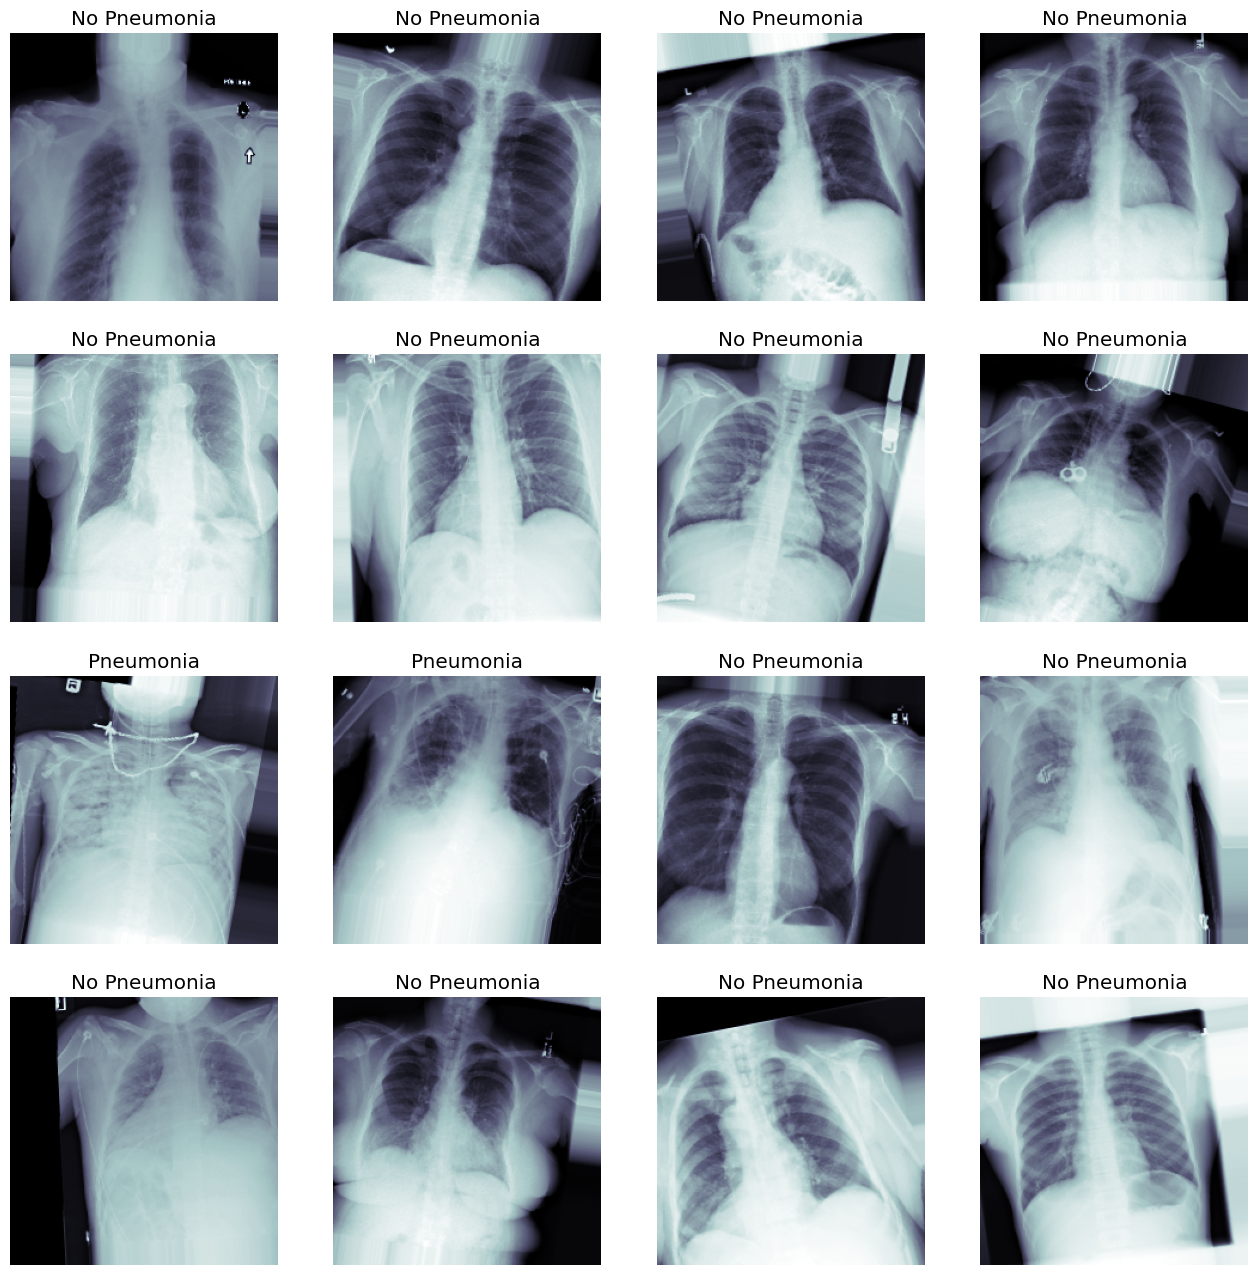

In [149]:
###### May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation
train_data['path'] = train_data['path'].astype(str)
train_idg = my_image_augmentation_train()
train_gen = make_train_gen(train_idg, train_data)

t_x, t_y = next(train_gen)
print("Batch Mean: " + str(t_x.mean()) + " Batch Std: " + str(t_x.std()))
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 
<a name="model-build"></a>
Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [150]:
def load_pretrained_vgg_model(layer_of_interest):
    
    model = VGG16(include_top=True, weights='imagenet')
    transfer_layer = model.get_layer(layer_of_interest)
    vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    for layer in vgg_model.layers[0:-2]:
        layer.trainable = False
    
    return vgg_model


In [151]:
def build_my_model(pretrained_model):
    
    my_model = Sequential()
    my_model.add(pretrained_model)
    my_model.add(Flatten())
    my_model.add(Dense(1024, activation = 'relu'))
    my_model.add(Dropout(0.5))
    my_model.add(Dense(512, activation = 'relu'))
    my_model.add(Dropout(0.5))
    my_model.add(Dense(256, activation = 'relu'))
    my_model.add(Dropout(0.5))
    my_model.add(Dense(1, activation = 'sigmoid'))
    
    optimizer = Adam(learning_rate = 1e-3)
    loss = 'binary_crossentropy'
    metrics = ['binary_accuracy']
    
    my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
#    my_model_history = my_model.fit_generator(train_gen, 
#                                             validation_data=(val_X, val_Y),
#                                             epochs=epochs)
    
    
    return my_model


## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

In [152]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

## Monitor Validation Binary accuracy, because the validation accuracy allows us to see if the model can be generalized
## to images that it wasn't trained on.  Validation accuracy is chosen over validation loss, because this problem
## is to detect Positive-Pneumonia or Negative-Pneumonia.

weight_path="/home/shafeenkhan/Documents/My-all-programs--/Semester-4/Aritificial Intelligence/Pneumonia_Detection_ChestX/out{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor= 'val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode= 'min', 
                             save_weights_only = True)

early = EarlyStopping(monitor= 'val_loss', 
                      mode= 'min', 
                      patience=10)

callbacks_list = [checkpoint, early]

### Start training! <a name="model-train"></a>

In [153]:
## train your model
vgg_model = load_pretrained_vgg_model('block5_pool')
my_model = build_my_model(vgg_model)
history = my_model.fit_generator(train_gen, 
                           validation_data = val_gen, 
                           epochs = 10,
                           callbacks = callbacks_list)

/tmp/ipykernel_49176/2928753405.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = my_model.fit_generator(train_gen,


Epoch 1/10
7/7 [==============================] - ETA: 0s - loss: 2.8362 - binary_accuracy: 0.3942
Epoch 00001: val_loss improved from inf to 0.51665, saving model to /home/shafeenkhan/Documents/My-all-programs--/Semester-4/Aritificial Intelligence/Pneumonia_Detection_ChestX/outxray_class_my_model.best.hdf5
7/7 [==============================] - 13s 2s/step - loss: 2.8362 - binary_accuracy: 0.3942 - val_loss: 0.5166 - val_binary_accuracy: 0.8000
Epoch 2/10
7/7 [==============================] - ETA: 0s - loss: 0.9564 - binary_accuracy: 0.5000
Epoch 00002: val_loss did not improve from 0.51665
7/7 [==============================] - 12s 2s/step - loss: 0.9564 - binary_accuracy: 0.5000 - val_loss: 0.7055 - val_binary_accuracy: 0.4462
Epoch 3/10
7/7 [==============================] - ETA: 0s - loss: 0.7032 - binary_accuracy: 0.5288
Epoch 00003: val_loss did not improve from 0.51665
7/7 [==============================] - 12s 2s/step - loss: 0.7032 - binary_accuracy: 0.5288 - val_loss: 0.613

In [154]:
def plot_history(history,epoch):
    plt.style.use('ggplot')
    plt.figure(figsize=(12,12))
    plt.style.use('ggplot')
    plt.plot(range(epoch),history.history['loss'],label='Loss', color='green')
    plt.plot(range(epoch),history.history['val_loss'],label='Validation_Loss', color = 'red')
    plt.plot(range(epoch),history.history['binary_accuracy'],label='Binary_Accuracy',color='blue')
    plt.plot(range(epoch),history.history['val_binary_accuracy'],label='Validation_Bin_Accuracy',color='purple')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss/Accuracy')
    plt.savefig('/home/shafeenkhan/Documents/My-all-programs--/Semester-4/Aritificial Intelligence/Pneumonia_Detection_ChestX/out/Model_Training_Performance')
    plt.show()

    return

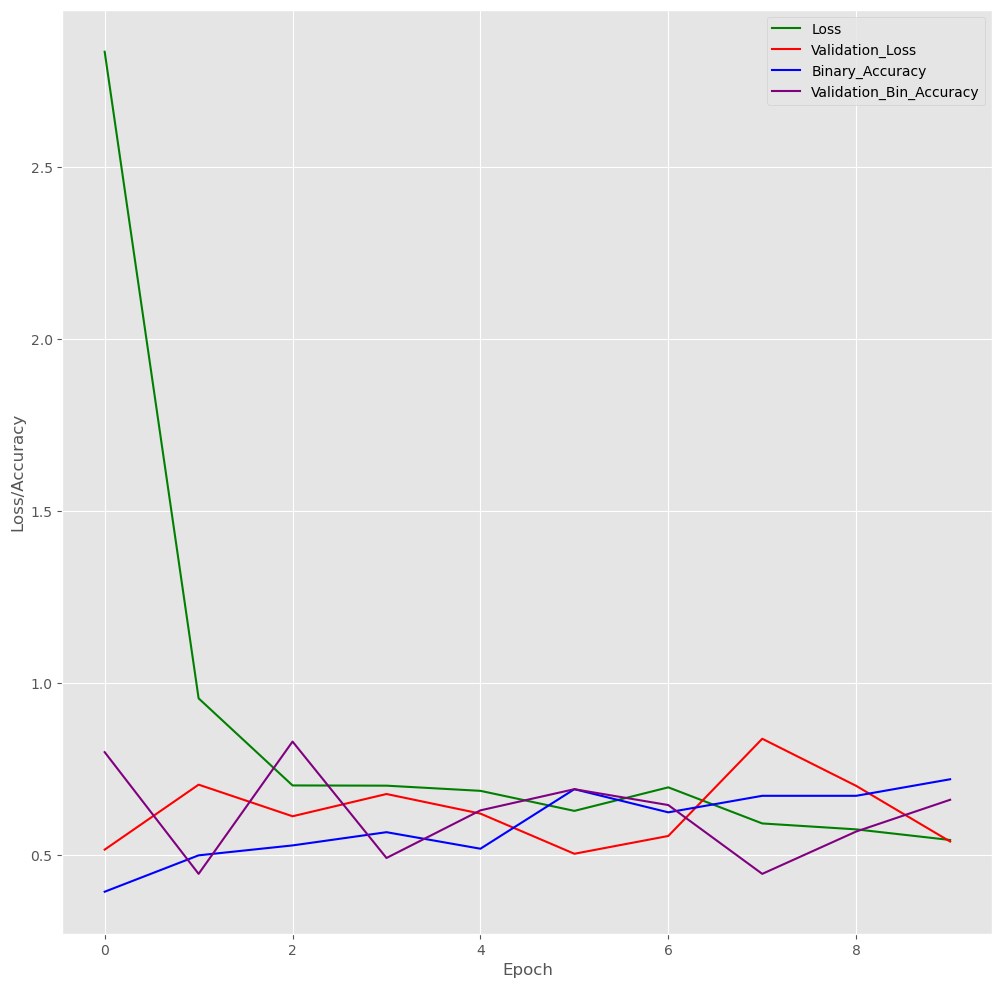

In [155]:
plot_history(history,10)

**Figure 1.** Model 1 Training History

In [156]:
performance = []

In [157]:
history_df=pd.DataFrame(history.history)
performance.append(history_df[history_df['val_loss']==min(history_df['val_loss'])])
performance

[       loss  binary_accuracy  val_loss  val_binary_accuracy
 5  0.629213         0.692308  0.504585             0.692308]

In [158]:
def build_my_model2(pretrained_model):
    "Add one Dense layer and one Dropout Layer"
    my_model = Sequential()
    my_model.add(pretrained_model)
    my_model.add(Flatten())
    my_model.add(Dense(2048, activation = 'relu'))
    my_model.add(Dropout(0.5))
    my_model.add(Dense(1024, activation = 'relu'))
    my_model.add(Dropout(0.5))
    my_model.add(Dense(512, activation = 'relu'))
    my_model.add(Dropout(0.5))
    my_model.add(Dense(256, activation = 'relu'))
    my_model.add(Dropout(0.5))
    my_model.add(Dense(1, activation = 'sigmoid'))
    
    optimizer = Adam(learning_rate = 1e-3)
    loss = 'binary_crossentropy'
    metrics = ['binary_accuracy']
    
    my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
     
    return my_model

In [159]:
#Train Model #2 with Dense and Dropout Layer
vgg_model = load_pretrained_vgg_model('block5_pool')
my_model2 = build_my_model2(vgg_model)
history2 = my_model2.fit_generator(train_gen, 
                           validation_data = val_gen, 
                           epochs = 10,
                           callbacks = callbacks_list)

/tmp/ipykernel_49176/2599443291.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history2 = my_model2.fit_generator(train_gen,


Epoch 1/10
7/7 [==============================] - ETA: 0s - loss: 2.6616 - binary_accuracy: 0.5385
Epoch 00001: val_loss did not improve from 0.50458
7/7 [==============================] - 13s 2s/step - loss: 2.6616 - binary_accuracy: 0.5385 - val_loss: 1.3987 - val_binary_accuracy: 0.2000
Epoch 2/10
7/7 [==============================] - ETA: 0s - loss: 1.1645 - binary_accuracy: 0.4904
Epoch 00002: val_loss did not improve from 0.50458
7/7 [==============================] - 13s 2s/step - loss: 1.1645 - binary_accuracy: 0.4904 - val_loss: 0.5981 - val_binary_accuracy: 0.8000
Epoch 3/10
7/7 [==============================] - ETA: 0s - loss: 0.7335 - binary_accuracy: 0.4808
Epoch 00003: val_loss did not improve from 0.50458
7/7 [==============================] - 12s 2s/step - loss: 0.7335 - binary_accuracy: 0.4808 - val_loss: 0.7008 - val_binary_accuracy: 0.3231
Epoch 4/10
7/7 [==============================] - ETA: 0s - loss: 0.6806 - binary_accuracy: 0.5769
Epoch 00004: val_loss did no

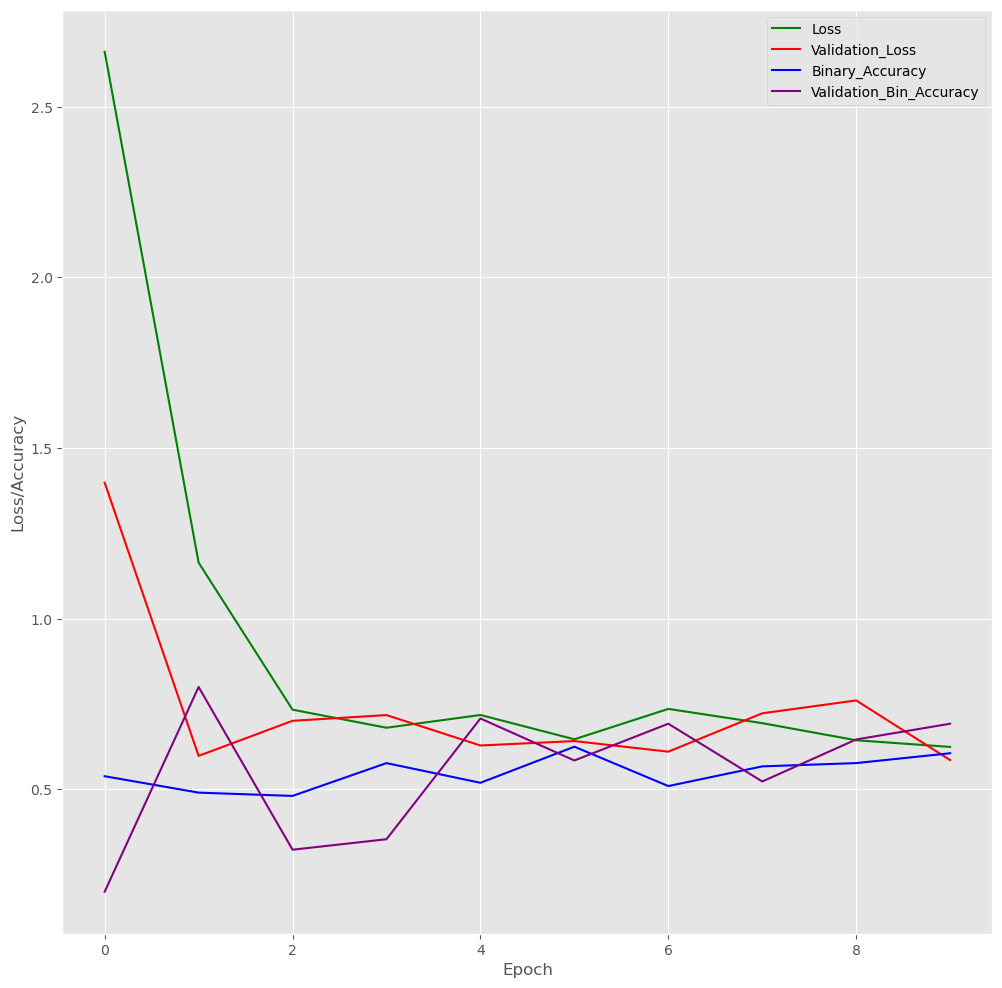

In [160]:
plot_history(history2,10)

**Figure 2.** Model 2 Training History

In [161]:
history2_df=pd.DataFrame(history2.history)
performance.append(history2_df[history2_df['val_loss']==min(history2_df['val_loss'])])
performance

[       loss  binary_accuracy  val_loss  val_binary_accuracy
 5  0.629213         0.692308  0.504585             0.692308,
        loss  binary_accuracy  val_loss  val_binary_accuracy
 9  0.624362         0.605769  0.585881             0.692308]

In [162]:
def build_my_model3(pretrained_model):
    "Change Learning rate from 1e-3 to 1e-4"
    my_model = Sequential()
    my_model.add(pretrained_model)
    my_model.add(Flatten())
    my_model.add(Dense(2048, activation = 'relu'))
    my_model.add(Dropout(0.5))
    my_model.add(Dense(1024, activation = 'relu'))
    my_model.add(Dropout(0.5))
    my_model.add(Dense(512, activation = 'relu'))
    my_model.add(Dropout(0.5))
    my_model.add(Dense(256, activation = 'relu'))
    my_model.add(Dropout(0.5))
    my_model.add(Dense(1, activation = 'sigmoid'))
    
    optimizer = Adam(learning_rate = 1e-4)
    loss = 'binary_crossentropy'
    metrics = ['binary_accuracy']
    
    my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
     
    return my_model

In [163]:
#Train Model3 
vgg_model = load_pretrained_vgg_model('block5_pool')
my_model3 = build_my_model3(vgg_model)
history3 = my_model3.fit_generator(train_gen, 
                           validation_data = val_gen, 
                           epochs = 10,
                           callbacks = callbacks_list)

/tmp/ipykernel_49176/3601672078.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history3 = my_model3.fit_generator(train_gen,


Epoch 1/10
7/7 [==============================] - ETA: 0s - loss: 0.9464 - binary_accuracy: 0.5577
Epoch 00001: val_loss did not improve from 0.50458
7/7 [==============================] - 13s 2s/step - loss: 0.9464 - binary_accuracy: 0.5577 - val_loss: 0.6719 - val_binary_accuracy: 0.6462
Epoch 2/10
7/7 [==============================] - ETA: 0s - loss: 1.0774 - binary_accuracy: 0.4712
Epoch 00002: val_loss did not improve from 0.50458
7/7 [==============================] - 13s 2s/step - loss: 1.0774 - binary_accuracy: 0.4712 - val_loss: 0.6003 - val_binary_accuracy: 0.8000
Epoch 3/10
7/7 [==============================] - ETA: 0s - loss: 1.1647 - binary_accuracy: 0.4808
Epoch 00003: val_loss did not improve from 0.50458
7/7 [==============================] - 12s 2s/step - loss: 1.1647 - binary_accuracy: 0.4808 - val_loss: 0.7694 - val_binary_accuracy: 0.2154
Epoch 4/10
7/7 [==============================] - ETA: 0s - loss: 1.0219 - binary_accuracy: 0.5192
Epoch 00004: val_loss did no

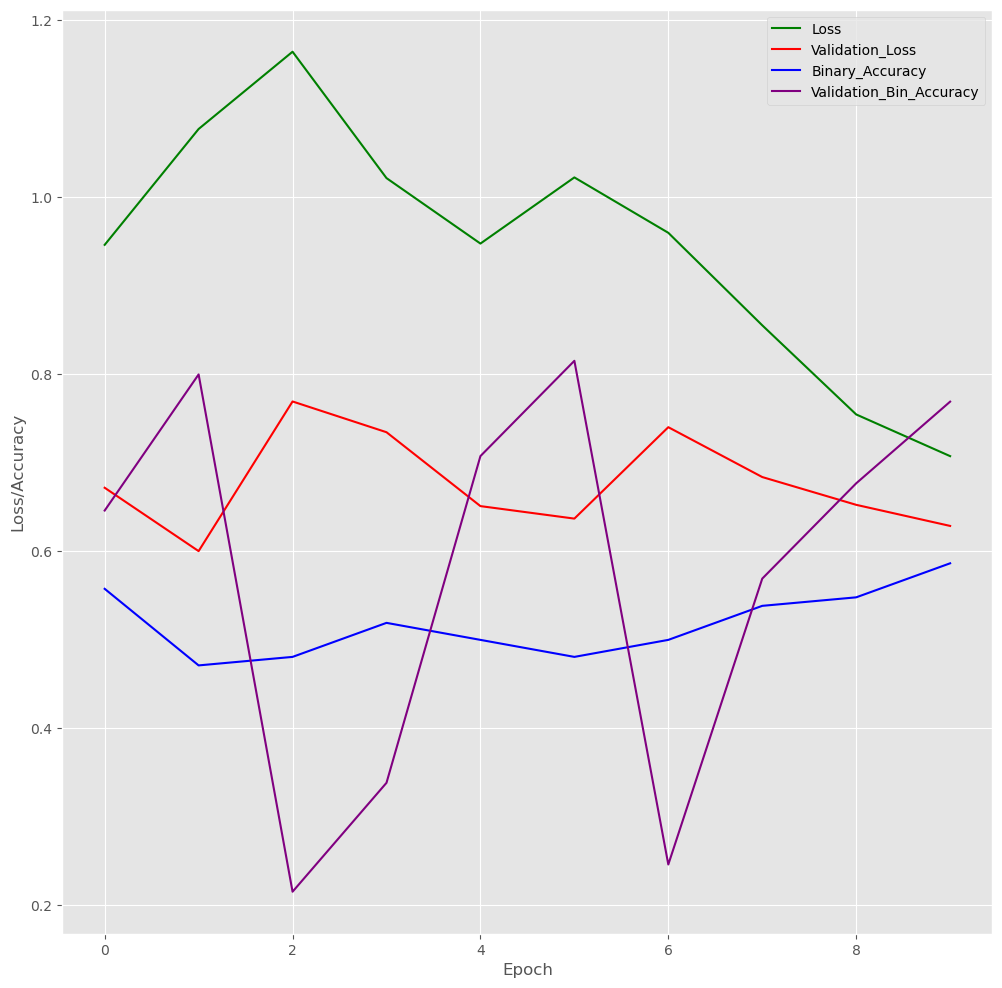

In [164]:
model3_plot = plot_history(history3,10)

**Figure 3.** Model 3 Training History

In [165]:
history3_df=pd.DataFrame(history3.history)
performance.append(history3_df[history3_df['val_loss']==min(history3_df['val_loss'])])

In [166]:
performance

[       loss  binary_accuracy  val_loss  val_binary_accuracy
 5  0.629213         0.692308  0.504585             0.692308,
        loss  binary_accuracy  val_loss  val_binary_accuracy
 9  0.624362         0.605769  0.585881             0.692308,
        loss  binary_accuracy  val_loss  val_binary_accuracy
 1  1.077354         0.471154  0.600309                  0.8]

###### Model 1 has the lowest val_loss.  Proceed with Model 1

##### After training for some time, look at the performance of your model by plotting some performance statistics:
<a name="model-eval"></a>
Note, these figures will come in handy for your FDA documentation later in the project

In [167]:
vgg_model = load_pretrained_vgg_model('block5_pool')
my_model1 = build_my_model(vgg_model)
my_model1.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_12 (Functional)       (None, 7, 7, 512)         14714688  
                                                                 
 flatten_12 (Flatten)        (None, 25088)             0         
                                                                 
 dense_54 (Dense)            (None, 1024)              25691136  
                                                                 
 dropout_42 (Dropout)        (None, 1024)              0         
                                                                 
 dense_55 (Dense)            (None, 512)               524800    
                                                                 
 dropout_43 (Dropout)        (None, 512)               0         
                                                                 
 dense_56 (Dense)            (None, 256)             

In [168]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.

vgg_model = load_pretrained_vgg_model('block5_pool')
my_model1 = build_my_model(vgg_model)
my_model1.load_weights(weight_path)
val_gen.reset()
pred_Y = my_model1.predict(val_gen, verbose = True)   

3/3 [==============================] - 4s 994ms/step


In [169]:
pred_Y.shape

(65, 1)

In [170]:
val_gen.labels

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [171]:
pred_Y = pred_Y.flatten().tolist()

In [172]:
predictions_df=pd.DataFrame({'Label':val_gen.labels,'Predict':pd.Series(pred_Y)})
predictions_df.sort_values('Label',ascending=False).head(10)

,Label,Predict
0,1,0.662846
7,1,0.647125
1,1,0.214297
11,1,0.724178
10,1,0.624843
9,1,0.160731
8,1,0.195216
12,1,0.401560
6,1,0.573180
5,1,0.747797


In [173]:
predictions_df[predictions_df['Label']==1.0]

,Label,Predict
0,1,0.662846
1,1,0.214297
2,1,0.715125
3,1,0.574234
4,1,0.896850
5,1,0.747797
6,1,0.573180
7,1,0.647125
8,1,0.195216
9,1,0.160731


In [174]:
predictions_df.to_csv('/home/shafeenkhan/Documents/My-all-programs--/Semester-4/Aritificial Intelligence/Pneumonia_Detection_ChestX/out/Predictions_best_model.csv')

In [175]:
predictions_df= pd.read_csv('/home/shafeenkhan/Documents/My-all-programs--/Semester-4/Aritificial Intelligence/Pneumonia_Detection_ChestX/out/Predictions_best_model.csv')
predictions_df

,Unnamed: 0,Label,Predict
0,0,1,0.662846
1,1,1,0.214297
2,2,1,0.715125
3,3,1,0.574234
4,4,1,0.896850
...,...,...,...
60,60,0,0.112950
61,61,0,0.479327
62,62,0,0.072709
63,63,0,0.266347


# ROC, Precision-Recall Curve, F1 Plot <a name="metrics-plots"></a>

In [176]:
def plot_roc(t_y, p_y):
    
    fpr, tpr, thresholds = roc_curve(t_y, p_y, pos_label = 1)
#    np.append(thresholds, 1)
    plt.plot(fpr,tpr)
    plt.style.use('ggplot')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='black',label='Chance', alpha=.8)
    plt.savefig('/home/shafeenkhan/Documents/My-all-programs--/Semester-4/Aritificial Intelligence/Pneumonia_Detection_ChestX/out/ROC_Curve')
    plt.show()
    
    return fpr, tpr, thresholds

## what other performance statistics do you want to include here besides AUC? 


def plot_precision_recall_curve(t_y, p_y):
    precision, recall, threshold = precision_recall_curve(t_y,p_y,pos_label = 1)
    threshold = np.append(threshold, 1)
    plt.style.use('ggplot')
    plt.plot(precision, recall)
    plt.title('Precision-Recall Curve')
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.savefig('/home/shafeenkhan/Documents/My-all-programs--/Semester-4/Aritificial Intelligence/Pneumonia_Detection_ChestX/out/Precision_Recall_Curve')
    plt.show()
    
    return precision, recall, threshold

def calc_f1(prec,recall):
    return 2*(prec*recall)/(prec+recall)

def plot_f1(t_y,p_y):
    precision, recall, threshold = plot_precision_recall_curve(t_y,p_y)
    f1 = calc_f1(precision, recall)
    plt.style.use('ggplot')
    plt.plot(threshold, f1)
    plt.title('F1 vs Threshold')
    plt.xlabel('Threshold')
    plt.ylabel('F1')
    plt.savefig('/home/shafeenkhan/Documents/My-all-programs--/Semester-4/Aritificial Intelligence/Pneumonia_Detection_ChestX/out/F1_Threshold')
    plt.show()
    
    return precision, recall, f1, threshold

def plot_auc(t_y, p_y):
    fig, ax = plt.subplots(figsize=(8,8))
    plt.style.use('ggplot')
    fpr, tpr, thresholds = plot_roc(t_y, p_y)
    res = auc(fpr, tpr)
    print("AUC-ROC is: " + str(res))
    return fpr, tpr, thresholds, res
    

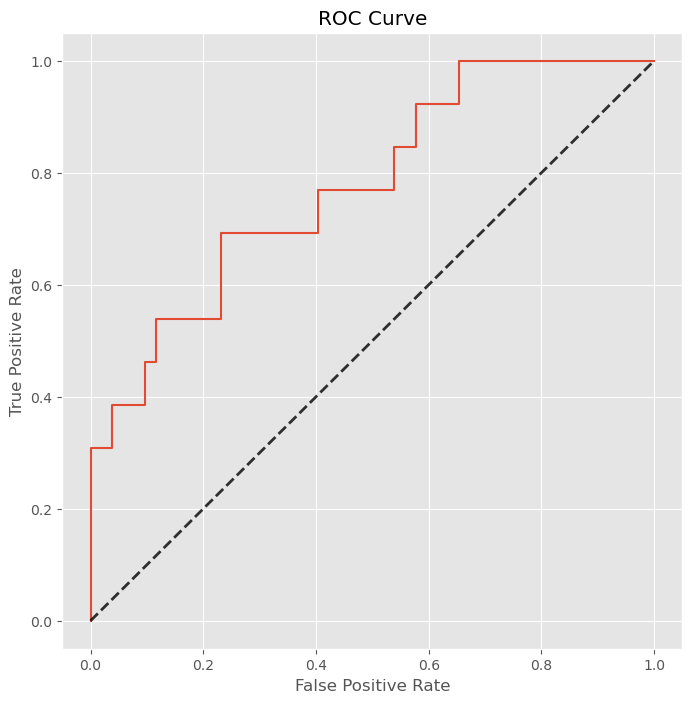

AUC-ROC is: 0.7781065088757396


In [177]:
fpr, tpr, thresholds_ROC, AUC = plot_auc(predictions_df['Label'],predictions_df['Predict'])


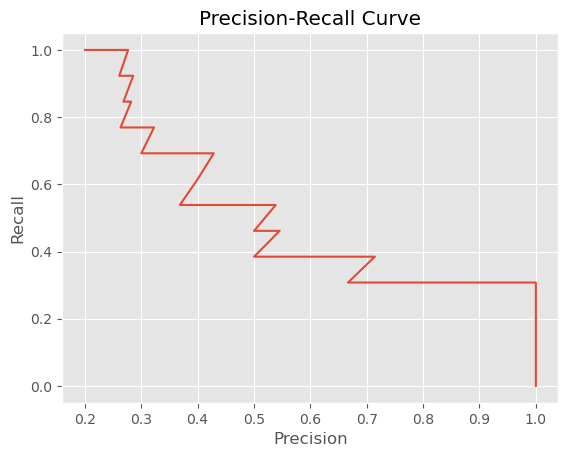

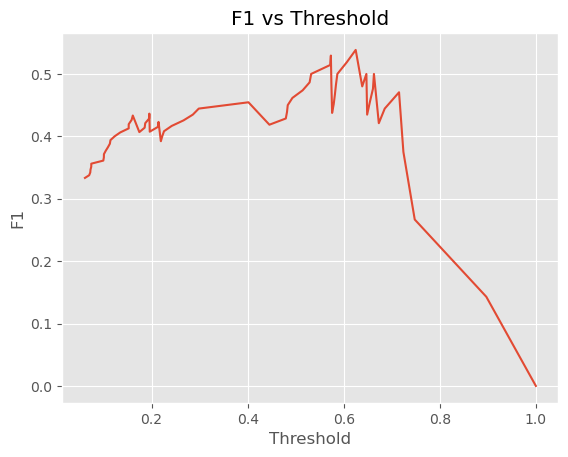

In [178]:
precision, recall, f1, thresholds_f1 = plot_f1(predictions_df['Label'],predictions_df['Predict'])

In [179]:
recall_df = pd.DataFrame({"Precision":precision, "Threshold":thresholds_f1, "Recall":recall, "F1":f1})

<a name="thresholding"></a>Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 


In [180]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

## If, this model can be used for screening studyies where High Recall is required, 
## reducing false negatives at the expense of more false positives.  This would 
## be found on the ROC curve where the distance away from Chance prediction is greatest.

def find_ROC_thresh(fpr,tpr,thresh):
    dist1=0
    dist2=0
    tprmax = 0
    for i in range(len(fpr)):
        dist2 = tpr[i] - fpr[i]
        if dist2 > dist1:
            dist1 = dist2
            tprmax=tpr[i]
        else:
            continue
    df = pd.DataFrame({'fpr':fpr,'tpr':tpr,'threshold':thresh})
    threshmax = df['threshold'][df['tpr']==tprmax].iloc[-1]
    return threshmax

## If this model is used for confirming a diagnosis, high precision is desired.
## An F1 Score is maximized where there is a balance between precision and recall.
## The corresponding threshold for that F1 Score should be chosen.

def find_F1_thresh(f1,thresh):
    df = pd.DataFrame({'f1':f1,'threshold':thresh})
    threshmax = df['threshold'][df['f1']==df['f1'].max()] .iloc[-1]
    return threshmax



In [181]:
thresh_ROC = find_ROC_thresh(fpr,tpr, thresholds_ROC)
print("thresh_ROC is " + str(thresh_ROC))

thresh_ROC is 0.4451873004436493


In [182]:
thresh_F1 = find_F1_thresh(f1, thresholds_f1)
print("Maximium F1-score is {} \nThreshhold for this F1-score is {}".format(str(np.max(f1)), str(thresh_F1)))

Maximium F1-score is 0.5384615384615384 
Threshhold for this F1-score is 0.624842643737793


In [183]:
val_gen_labels= pd.DataFrame(val_gen.labels)
val_Pos_labels= val_gen_labels[val_gen_labels[0] > 0]
val_Pos_labels
val_Pos_ind=val_Pos_labels.index
val_Pos_ind

Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], dtype='int64')

In [184]:
val_filenames = np.array(val_gen.filenames)
val_labels=np.array(val_gen.labels)

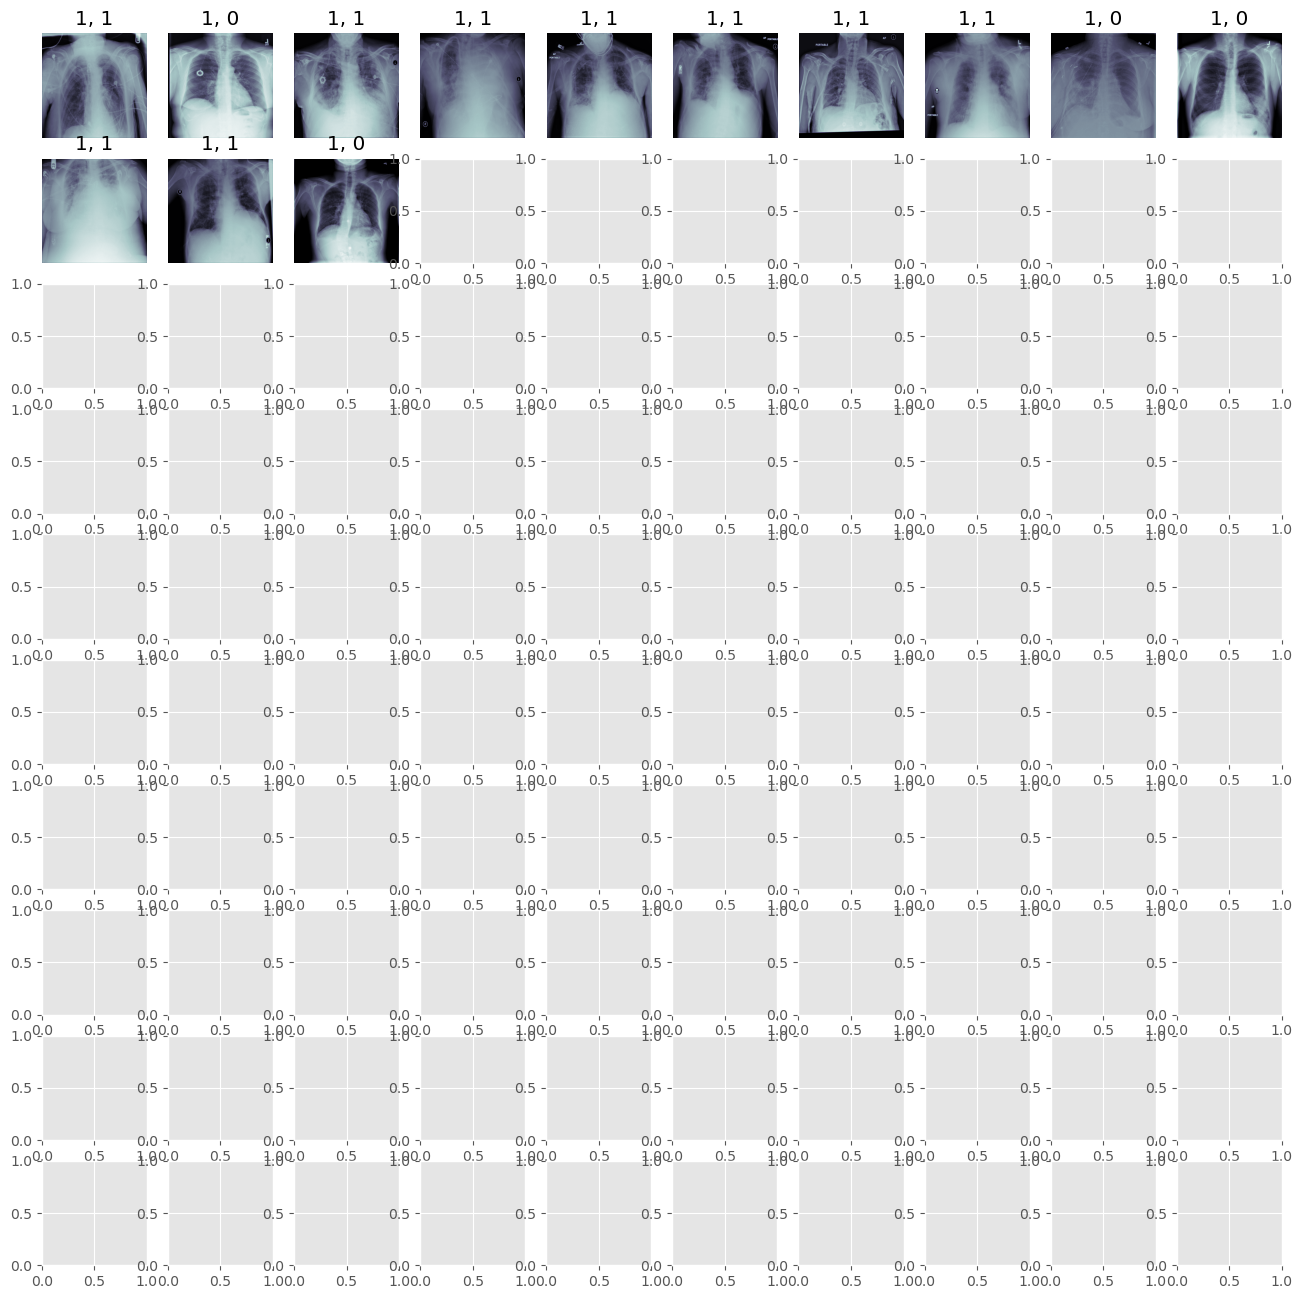

In [185]:
## Let's look at some examples of true vs. predicted with our best model based on thresh_ROC: 
Thresh=thresh_ROC

fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(val_filenames[val_Pos_ind], val_labels[val_Pos_ind], m_axs.flatten()):
    c_ax.imshow(imread(c_x), cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > Thresh:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > Thresh: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

**Figure 4.** 100 Images with titles showing "Label Value, Prediction Value" for pneumonia, using ROC Threshold 

In [186]:
#ROC Threshold Confusion Matrix:
pred_YROC = []

for x in range(len(pred_Y)):
    if pred_Y[x] > thresh_ROC:
        pred_YROC.append(1)
    else:
        pred_YROC.append(0)

tn,fp,fn,tp =confusion_matrix(val_gen.labels,pred_YROC).ravel()
print (tp, fp,"\n",fn,tn)

9 20 
 4 32


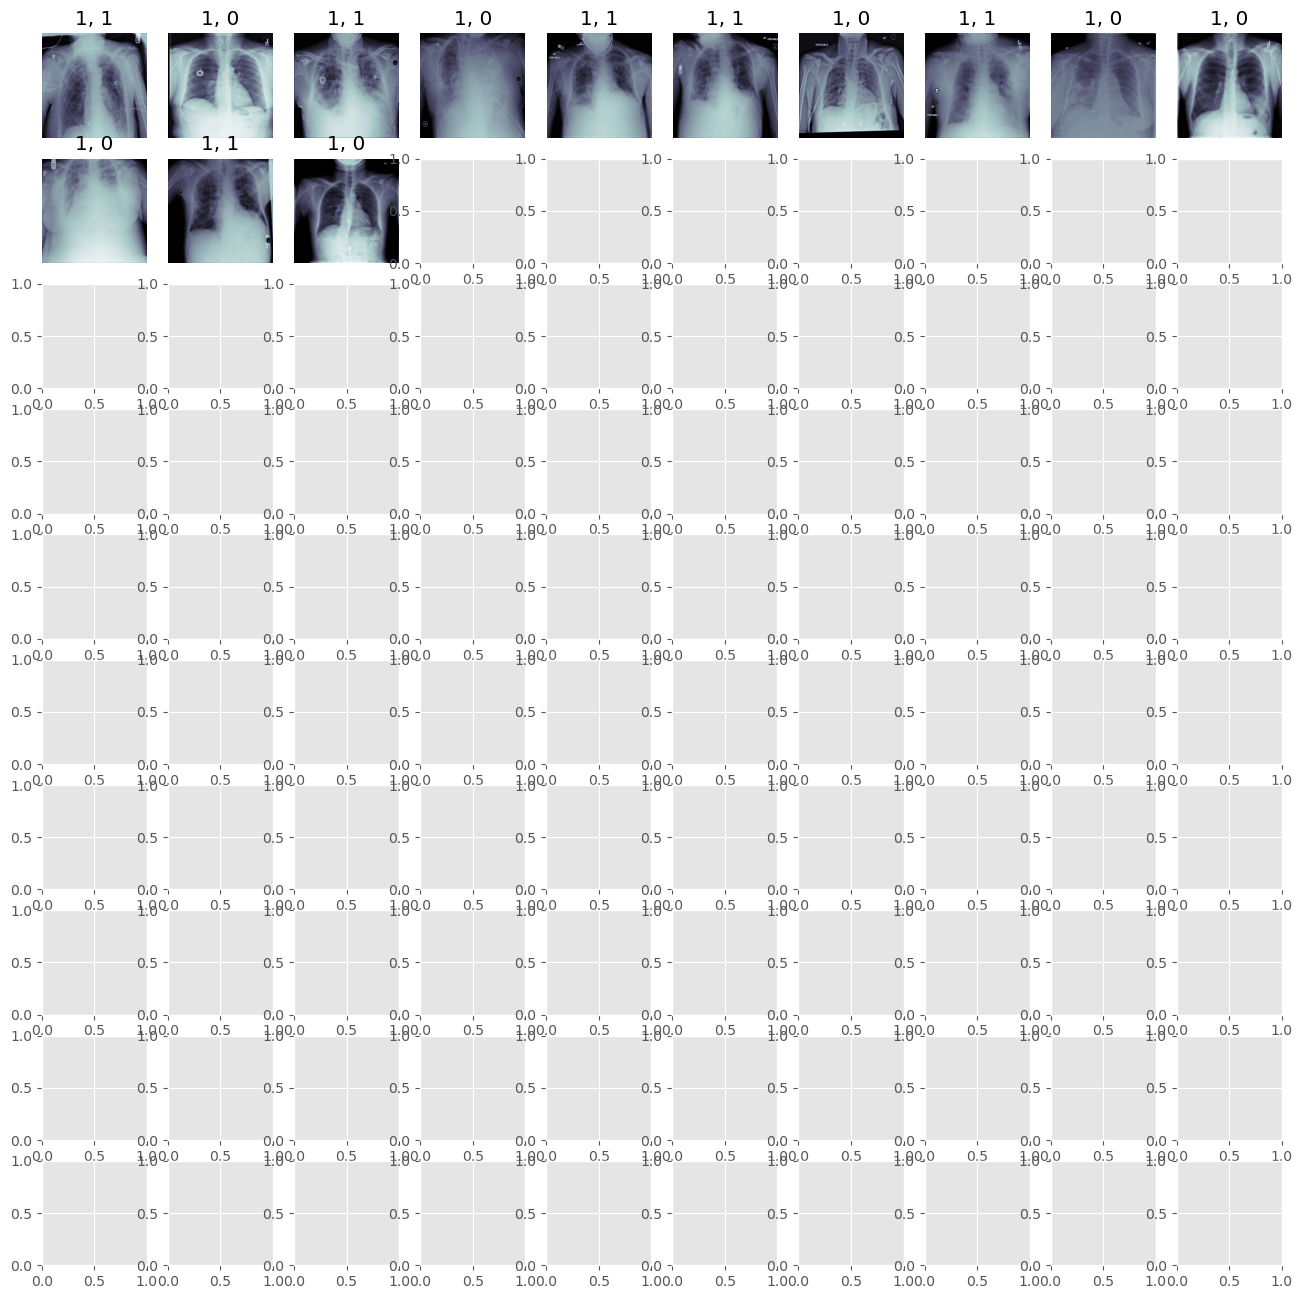

In [187]:
## Let's look at some examples of true vs. predicted with our best model based on thresh_F1: 
Thresh=thresh_F1

fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(val_filenames[val_Pos_ind], val_labels[val_Pos_ind], m_axs.flatten()):
    c_ax.imshow(imread(c_x), cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > Thresh:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > Thresh: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

**Figure 5.** 100 Images with titles showing "Label Value, Prediction Value" for pneumonia, using F1-score Threshold 

In [188]:
#F1 Threshold Confusion Matrix:
pred_YF1 = []

for x in range(len(pred_Y)):
    if pred_Y[x] > thresh_F1:
        pred_YF1.append(1)
    else:
        pred_YF1.append(0)

tn,fp,fn,tp = confusion_matrix(val_gen.labels,pred_YF1).ravel()
print (tp, fp,"\n",fn,tn)

6 6 
 7 46


In [189]:
#Maximize Recall.  Choose Threshold at recall at 0.8.
recall_df[recall_df['Recall']>0.8]

,Precision,Threshold,Recall,F1
0,0.200000,0.061094,1.000000,0.333333
1,0.203125,0.069927,1.000000,0.337662
2,0.206349,0.072170,1.000000,0.342105
3,0.209677,0.072709,1.000000,0.346667
4,0.213115,0.074245,1.000000,0.351351
5,0.216667,0.074272,1.000000,0.356164
6,0.220339,0.099344,1.000000,0.361111
7,0.224138,0.100466,1.000000,0.366197
8,0.228070,0.100620,1.000000,0.371429
9,0.232143,0.104352,1.000000,0.376812


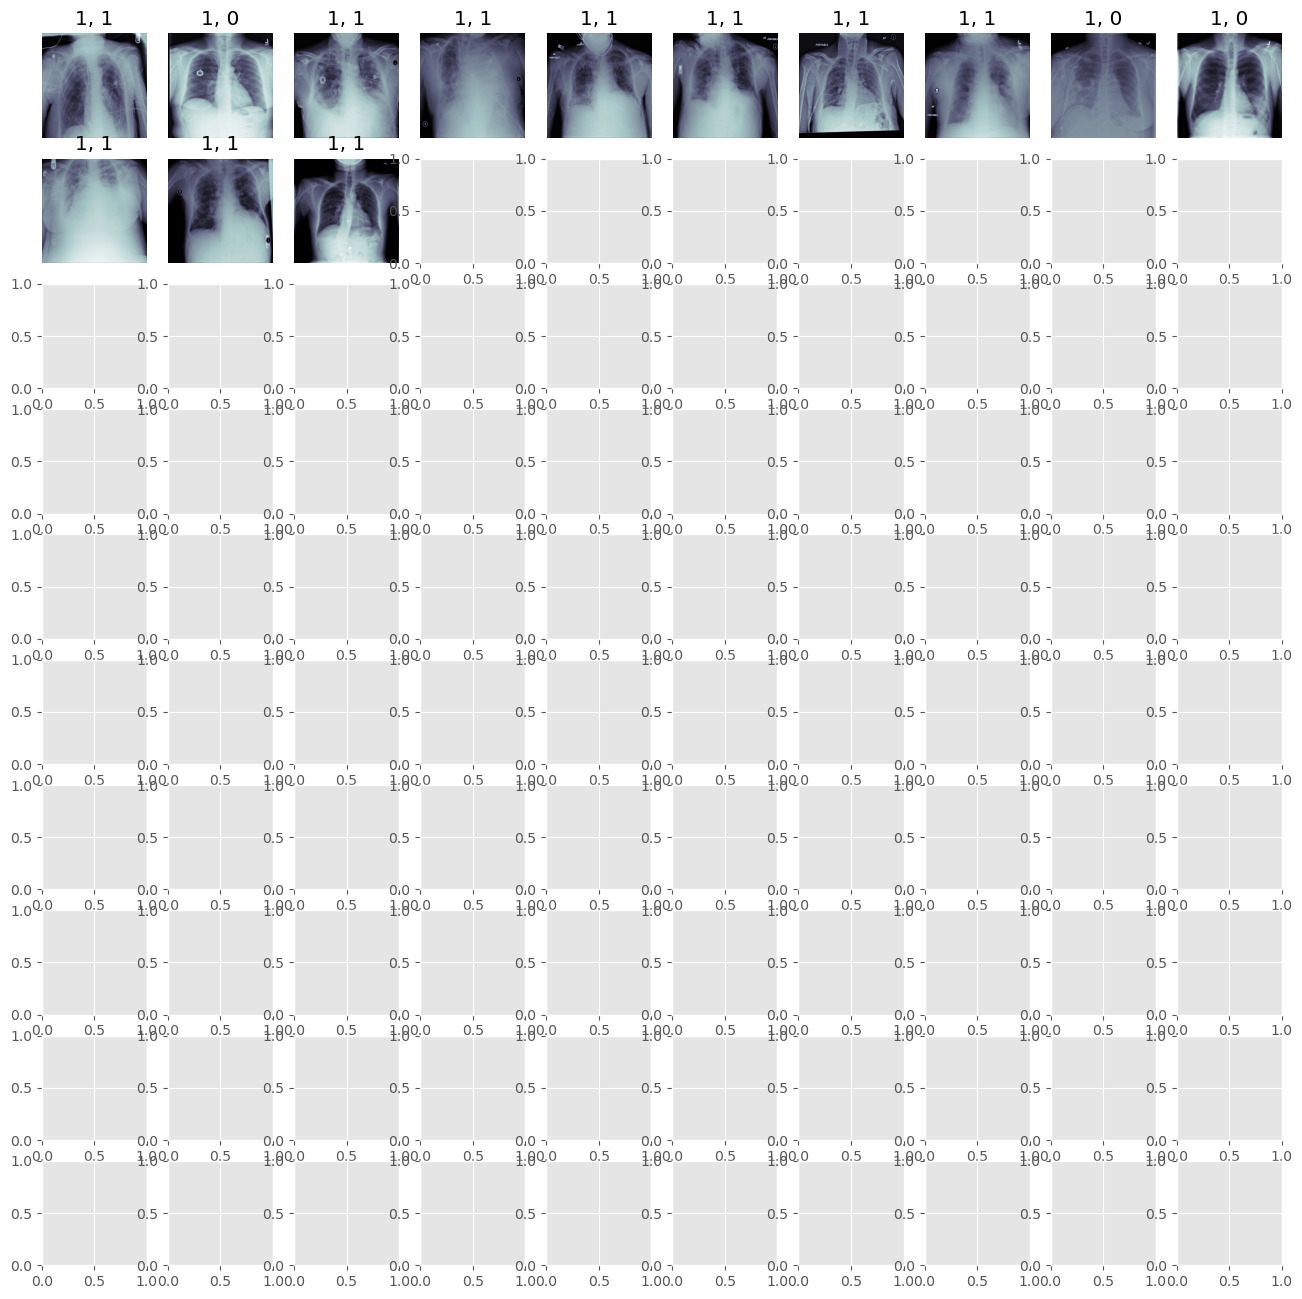

In [190]:
## Let's look at some examples of true vs. predicted with our best model maximizing Recall.  Recall=0.80: 
Thresh =  0.355

fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(val_filenames[val_Pos_ind], val_labels[val_Pos_ind], m_axs.flatten()):
    c_ax.imshow(imread(c_x), cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > Thresh:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > Thresh: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

**Figure 6.** 100 Images with titles showing "Label Value, Prediction Value" for pneumonia, using Recall Threshold 

In [191]:
thresh_recall = 0.355

pred_Yrecall = []

for x in range(len(pred_Y)):
    if pred_Y[x] > thresh_recall:
        pred_Yrecall.append(1)
    else:
        pred_Yrecall.append(0)

tn,fp,fn,tp = confusion_matrix(val_gen.labels,pred_Yrecall).ravel()
print (tp, fp,"\n",fn,tn)

10 21 
 3 31


<a name="results"></a>
#### The performance of three thresholds was explored by optimizing by ROC, by F1, and by maximizing Recall.  

#### 1.  Optimize Threshold value by ROC is seen above.  Based on images from the validation set with Positive Pneumonia labels, we see that the threshold value from ROC (0.24046) identifies some Positive Pneumonia labels correctly.  Based on it's corresponding confusion matrix, it yields 219 TP, 67 FN, 701 FP.

#### 2.  Optimize Threshold value by F1.  Based on images from the validation set with Positive Pneumonia labels, we see that the threshold value from F1 (0.24509) identifies some Positive Pneumonia labels correctly.  Based on it's corresponding confusion matrix, it yields 218 TP and 68 FN, 692 FP.  The performance is similar to optimizing by ROC.  With this threshold, the F1 score is 0.366.

#### 3.  Maximize recall.  A threshold value of 0.355 was chosen where Recall is above 0.80.  It's corresponding confusion matrix, it yields 124 TP, 162 FN, with 351 FP.  Though this method should have favored increasing TP at the cost of FN, this did not yield a result that is more aggressive that optimizing by ROC or F1.


#### For this project, model1 is the best architecture and its optimal threshold value is 0.24509 as determined from F1.  This combination yields a F1 score of 0.366.

In [192]:
## Just save model architecture to a .json:
model_json = my_model1.to_json()

with open("/home/shafeenkhan/Documents/My-all-programs--/Semester-4/Aritificial Intelligence/Pneumonia_Detection_ChestX/out/my_model1.json", "w") as json_file:
    json_file.write(model_json)